In [3]:
import numpy as np
import sys
import time
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import load_digits
from ipywidgets import interact
from sklearn.decomposition import PCA

In [124]:
def sigmoid(X):
    return 1. / (1. + np.exp(-X))

def sigmoid_grad(X):
    return sigmoid(X) * ( 1 - sigmoid(X) )

def relu(X):
    return (X + np.abs(X)) / 2.

def relu_grad(X):
#     return relu(X) - relu(X-1)
    return sigmoid(X)

class NeuralNetworkWithPCA(object):
    def __init__(self, num_input=2, num_hidden=2, num_output=1, learning_rate=0.1, num_epochs=10, activation='relu', use_pca=False, use_pca_2=False):
        self.num_input = num_input
        self.num_hidden = num_hidden
        self.num_output = num_output
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.use_pca = use_pca
        self.use_pca_2 = use_pca_2
        
        # self.weights_0_1 = np.zeros((num_input, num_hidden))
        self.weights_0_1 = np.random.randn(num_input, num_hidden)
        # self.weights_1_2 = np.zeros((num_hidden, num_output))
        self.weights_1_2 = np.random.randn(num_hidden, num_output)
        
        self.activation, self.activation_grad = self._activation_function(activation)
        self.training_accuracy = np.zeros((self.num_epochs))
        self.mse = np.zeros((self.num_epochs))
        self.weights_0_1_history = np.zeros((self.num_epochs+1, num_input, num_hidden))
        self.weights_1_2_history = np.zeros((self.num_epochs+1, num_hidden, num_output))
        self.weights_0_1_history[0] = self.weights_0_1
        self.weights_1_2_history[0] = self.weights_1_2
    
    def _initialise_pca(self, X):
        pca = PCA(n_components=self.num_hidden)
        pca.fit(X)
        for i in range(self.num_hidden):
            self.weights_0_1.T[i] = pca.components_[i]
        if self.use_pca_2:
            pca2 = PCA(n_components=self.num_output)
            Xt = self._layer_0_transform(X, epoch=0)
            pca2.fit(Xt)
            for i in range(self.num_output):
                self.weights_1_2.T[i]=pca2.components_[i]
    
    def _activation_function(self, name):
        funcs = {
            'relu': (relu, relu_grad),
            'sigmoid': (sigmoid, sigmoid_grad),
        }
        return funcs[name]
    
    def _compute_gradient(self, x, y):
        pass
    
    def _forward(self, X):
        self.input = X
        self.hidden = self.activation(np.dot(self.input, self.weights_0_1))
        self.output = self.activation(np.dot(self.hidden, self.weights_1_2))
        return self.output
    
    def fit(self, X, y):
        n = X.shape[0]
        
        if self.use_pca:
            self._initialise_pca(X)
        
        start = time.time()
        num_progress_bars = 20
        
        for i in range(self.num_epochs):
            self._forward(X)
            error = y - self.output
            self.grad_output = error * self.activation_grad(self.output)
            self.grad_hidden = np.dot(self.grad_output, self.weights_1_2.T) * self.activation_grad(self.hidden)
            self.dw_1_2 = np.dot(self.hidden.T, self.grad_output)
            self.dw_0_1 = np.dot(self.input.T, self.grad_hidden)
            self.weights_1_2 += self.learning_rate * self.dw_1_2 / n
            self.weights_0_1 += self.learning_rate * self.dw_0_1 / n
            
            self.weights_0_1_history[i+1] = self.weights_0_1
            self.weights_1_2_history[i+1] = self.weights_1_2

            finish = time.time()
            elapsed_time = float(time.time() - start)

            # l2_error = np.linalg.norm(error, ord=2, axis=1)
            correct = len([e for e in error if abs(e) < 0.5])
            training_accuracy = float(correct) / n
            self.training_accuracy[i] = training_accuracy
            
            mse = np.sum(error**2) / n
            self.mse[i] = mse
            
            progress = round(float(i)/self.num_epochs * num_progress_bars)

            # sys.stdout.write("\r" + " "*80)
            # print('\x1b[2K', end='\r')
            print("\r" + " "*80, end='\r')
            # sys.stdout.write(("\rTraining Accuracy: %0.3g%% Time elapsed: %0.2gs |" + "="*(progress) + " "*(num_progress_bars-progress) + "|") % (training_accuracy * 100, elapsed_time))
            print("\r" + ("Training Accuracy: %0.3g%% Time elapsed: %0.2gs |" + "="*(progress) + " "*(num_progress_bars-progress) + "|") % (training_accuracy * 100, elapsed_time), end='\r')
    
    def predict(self, X):
        return self.predict_proba(X)
    
    def predict_proba(self, X):
        return self._forward(X)
    
    def score(self, X, y):
        n = X.shape[0]
        self._forward(X)
        error = y - self.output
        correct = len([e for e in error if abs(e) < 0.5])
        training_accuracy = float(correct) / n
        return training_accuracy
    
    def _mse(self, X, y, epoch=None):
        n = X.shape[0]
        output = self._forward_history(X, epoch=epoch)
        mse = (y - output)**2
        return np.sum(error) / n
    
    def _layer_0_transform(self, X, epoch=None):
        epoch = self.num_epochs - 1 if epoch is None else epoch
        return self.activation(np.dot(X, self.weights_0_1_history[epoch]))
    
    def _forward_history(self, X, epoch=None):
        epoch = self.num_epochs - 1 if epoch is None else epoch
        hidden = self.activation(np.dot(X, self.weights_0_1_history[epoch]))
        output = self.activation(np.dot(hidden, self.weights_1_2_history[epoch]))
        return output

In [125]:
n = 1000
d = 10
X = np.random.randn(n, d)
m = np.median(np.linalg.norm(X, axis=1))
y = np.array([1 if np.linalg.norm(x) >= m else 0 for x in X])
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, shuffle=True, random_state=42)

/Users/AnnaLeonard/miniconda3/envs/py3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [132]:
np.random.seed(41)
num_epochs=10000
num_hidden=10
nn = NeuralNetworkWithPCA(num_input=d, num_hidden=num_hidden, num_epochs=num_epochs, learning_rate=0.1, use_pca=False)
nn_pca = NeuralNetworkWithPCA(num_input=d, num_hidden=num_hidden, num_epochs=num_epochs, learning_rate=0.1, use_pca=True)
nn_pca_2 = NeuralNetworkWithPCA(num_input=d, num_hidden=num_hidden, num_epochs=num_epochs, learning_rate=0.1, use_pca=True, use_pca_2=True)
nn_pca.weights_1_2 = nn.weights_1_2.copy()
nn.fit(X_train, y_train[:, None])
nn_pca.fit(X_train, y_train[:, None])
nn_pca_2.fit(X_train, y_train[:, None])

In [133]:
print("NN: %0.3g%%, NN with PCA: %0.3g%%, NN with PCA both: %0.3g%%" % (100*nn.score(X_test, y_test[:, None]), 100*nn_pca.score(X_test, y_test[:, None]), 100*nn_pca_2.score(X_test, y_test[:, None])))

NN: 72.4%, NN with PCA: 71.6%, NN with PCA both: 75.2%


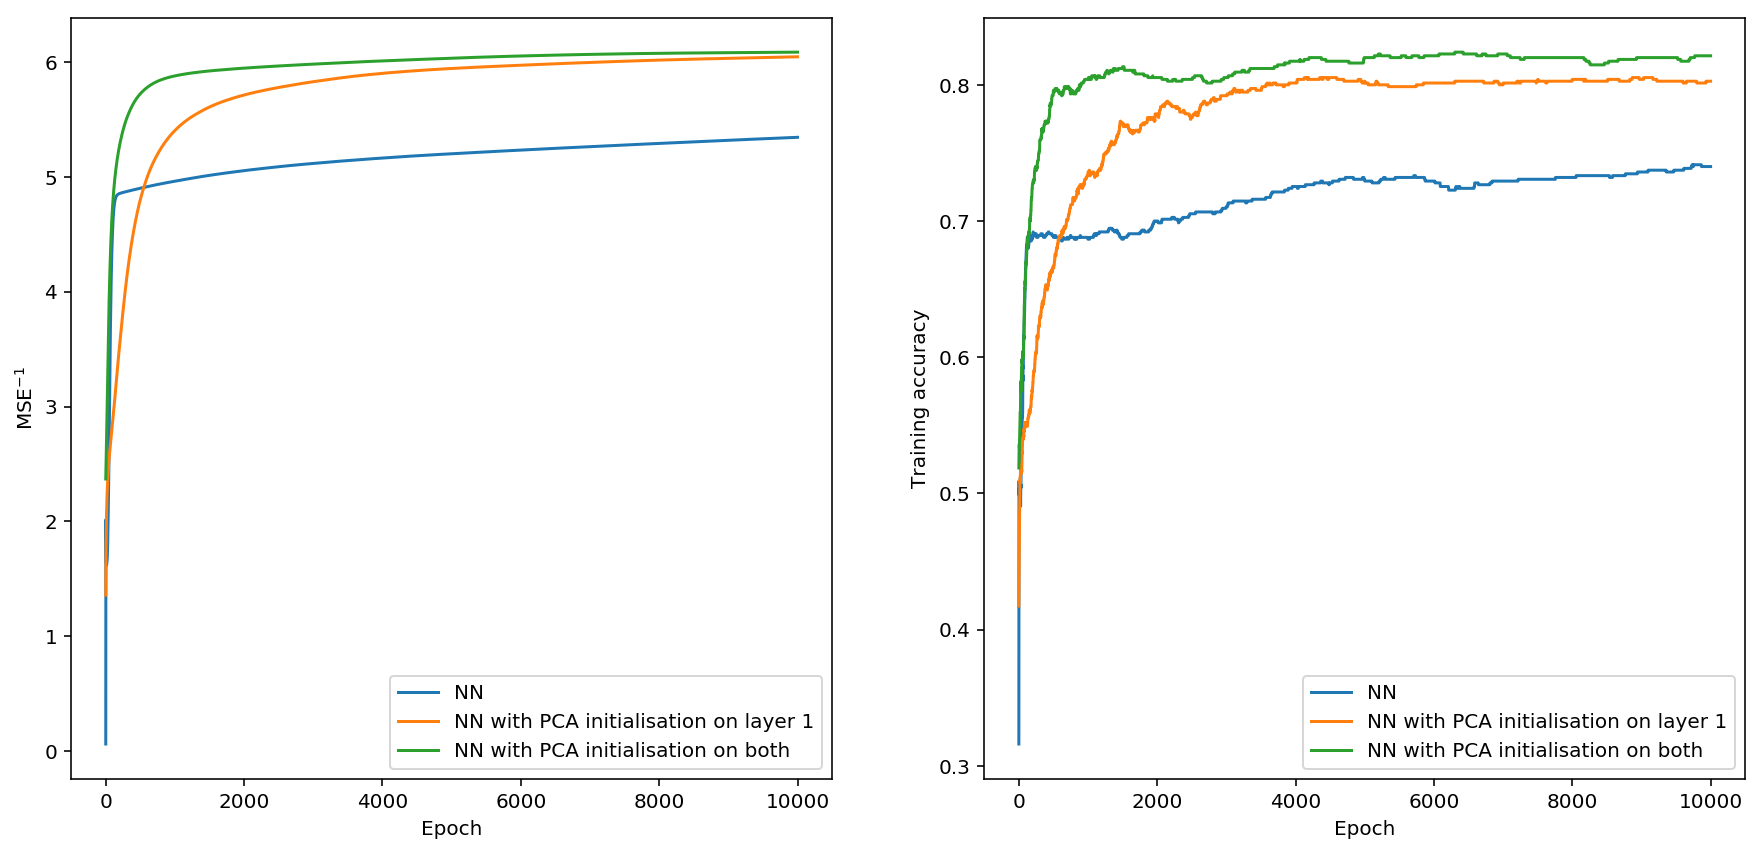

In [134]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(121)
ax.plot(nn.mse**-1, label="NN")
ax.plot(nn_pca.mse**-1, label="NN with PCA initialisation on layer 1")
ax.plot(nn_pca_2.mse**-1, label="NN with PCA initialisation on both")
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE$^{-1}$')
ax.legend()
ax2 = fig.add_subplot(122)
ax2.plot(nn.training_accuracy, label="NN")
ax2.plot(nn_pca.training_accuracy, label="NN with PCA initialisation on layer 1")
ax2.plot(nn_pca_2.training_accuracy, label="NN with PCA initialisation on both")
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Training accuracy')
ax2.legend()

# Remarks

PCA initialization seems to offer benefits early on in training, but eventually random initialisation catches up. Next, I am curious about whether initialising lots of 

In [123]:
@interact(epoch=(0,nn.num_epochs-1))
def plot_transform(epoch):
    Xt = nn._layer_0_transform(X_test, epoch=epoch)
    c0t = select_class(Xt, y_test, class_val=0)
    c1t = select_class(Xt, y_test, class_val=1)

    fig = plt.figure(figsize=(15,7))
    ax = fig.add_subplot(121, projection='3d')
    ax.scatter(c0t[:, 0], c0t[:, 1], c0t[:, 2])
    ax.scatter(c1t[:, 0], c1t[:, 1], c1t[:, 2])
    
    ax2 = fig.add_subplot(122)
    ax2.plot(nn.training_accuracy, color='blue')
    ax2.scatter(epoch, nn.training_accuracy[epoch], color='blue', s=100)
    
    plt.show()

interactive(children=(IntSlider(value=4999, description='epoch', max=9999), Output()), _dom_classes=('widget-interact',))

In [51]:
epoch=4999
Xt = nn._layer_0_transform(X_test, epoch=epoch)
c0t = select_class(Xt, y_test, class_val=0)
c1t = select_class(Xt, y_test, class_val=1)

In [47]:
def select_class(X, y, class_val=1):
    return np.array([X[i] for i in range(len(y)) if y[i] == class_val])

In [52]:
c0t

array([], dtype=float64)